Visualizing sleep with DBSCAN 
====================
This notebook visualizes sleep clusters using DBSCAN  from the scikit-learn library.

Use of DBSCAN
-----------------------
DBSCAN is used to identify clusters of sleep periods in the data.

1. Get Series of start-sleep and end-sleep timings in radian from *get_x_from_df()*. In This method, time in the format of _HH:MM_ is converted into radian using the _convert_to_radian()_ method.

2. Create a new dataframe containing the radian values of start-sleep and end-sleep from (1)

3. Calculate the eps and minPts – parameters used for DBSCAN

4. Create a pairwise distance matrix using from the dataframe in (2)

5. Call the _dbscan()_ method with the following parameters: eps, min_pts, X. eps and minPts are calculated in (3) and X is your pairwise distance matrix. Metric has been set to 'precomputed' as the pairwise distance matrix has been generated from (4)

This process will return you the following variables: *labels_, components_, core_sample_indices_*. *labels_* refer to the cluster label of each data point, i.e which cluster do they belong to. Values can be from 0 to n where n refers to the total number of clusters. Noise points are indicated with -1.


<span style="color:red">NOTE: here we choose the EPS as 1 hour, and the minPts as half of the data sample day</span>.


In [1]:
%matplotlib inline
###########################################IMPRORTS#########################################
from os import listdir
from os.path import isfile, join
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
from math import pi,ceil
from sklearn.cluster import DBSCAN
from sklearn.neighbors import DistanceMetric
from matplotlib.dates import HourLocator,MonthLocator, DateFormatter
from dateutil.relativedelta import relativedelta
#import eps_min_pts as eps_And_MinPts
#import helper_adl as h
#from matplotlib.backends.backend_pdf import PdfPages
###########################################IMPRORTS#########################################




In [2]:
# To return value in mins / total mins in one day
def to_mins(x):
    x = pd.Timestamp(x)
    year = x.year
    month =  x.month
    day = x.day
    return (x.value - pd.Timestamp(str(year)+'-'+str(month)+'-'+str(day)).value) / (60 * (10**9))
def to_date(x):
    x = pd.Timestamp(x)
    year = x.year
    month =  x.month
    day = x.day
    return pd.Timestamp(str(year)+'-'+str(month)+'-'+str(day))
# Helper method to convert values to radian
def convert_to_radian(x):
    return ((x / (24*60)) * 2 * pi)

def get_distance_from_df(series):
    # Vectorizing to_mins and to_radian functions
    tmin = np.vectorize(to_mins)
    # Converting series of timestamp -> minutes 
    df_minute = tmin(series)
    # Convert time to rad points   
    X = df_minute[None,:] - df_minute[:,None]
    X = abs(X)
    X[(X > 12*60)] = 24*60 - X[(X > 12*60)] 
    #X[(X <= (-12*60))] = X[((X > (-2*pi)) & (X <= (-1*pi)))] + (2*pi) 
    distance_matrix = X
    return distance_matrix,df_minute
# Returns output from sklearn DBSCAN method
def dbscan(eps, min_pts, X, metric='precomputed'):
    db = DBSCAN(eps, min_pts, metric)
    db.fit(X)
    return db.labels_

# Configures polar plot with 24 hour tick labels
def configure_polar_plot(axes):
    xticklabels = [str(x) for x in range (0,24)]
    axes.set_xticks(np.linspace(0,23,24,endpoint=True, dtype=np.int32) / 24 * (2 * np.pi))
    axes.set_xticklabels(xticklabels)
    axes.set_theta_zero_location('N')
    axes.set_theta_direction(-1)
    axes.set_ylim([0,1])
    axes.set_yticks([0.8,0.6])
    axes.set_yticklabels(['Sleep-Start', 'Sleep-End'])
    
    return axes

def plot_clusters(labels,tseries, axes, ring):
    
    # convert the distance to the radious distance
    trad = np.vectorize(convert_to_radian)
    rad_tseries = trad(tseries)
    unique_labels = set(labels)
    colors = plt.cm.Spectral(np.linspace(0, 1, len(unique_labels)))
    for k,col in zip(unique_labels, colors):
        marker = '.'
        ms = 25.0
        rate = (1+k*0.1)*ring
        if k == -1:
            col='k'
            marker = 'x'
            ms = 8.0
            rate = ring

        indices_of_k, = np.where(labels == k)
        data = rad_tseries.take(indices_of_k)
        #print("ring is {},lable is {},data is {}".format(ring,k,data))
        
        axes.plot(data, [rate for x in data], color=col, marker=marker, linestyle='none', ms=ms, mec='k')

def get_clusters_info(label,series,eps):
    info = ""
    for cluster_i in set(label):
        if cluster_i!=-1:
            #print(cluster_i)
            indices_of_k = np.where(label == cluster_i)
            data = series.take(indices_of_k)
            #print(data)
            data_min = np.min(data)
            #print(data_min)
            data_max = np.max(data)
            if data_max > 12*60 and data_min< 12*60:
                data_min_ = np.min(data[data>12*60])
                data_max_ = np.max(data[data<12*60])
                if (data_min_ - data_max_) > 2*eps:
                    data_max = np.max(data[data<12*60])
                    data_min = np.min(data[data>12*60])
            date_min = pd.to_datetime(data_min*(60*10**9))
            date_max = pd.to_datetime(data_max*(60*10**9))
            print("Cluster {}, start time:{}".format(cluster_i,date_min.strftime("%H:%M:%S")))
            print("Cluster {}, end time:{}".format(cluster_i,date_max.strftime("%H:%M:%S")))
            info += "\n Cluster {}, start time:{}, end time:{}".format(cluster_i,date_min.strftime("%H:%M:%S"),date_max.strftime("%H:%M:%S"))
            
    return info
# customize the distance calculations 
def customized_kmean_function(x,y):
    distance_temp = np.abs(x-y)
    distance_temp[distance_temp>12*60]=24*60 - distance_temp[distance_temp>12*60]
    return np.sqrt(np.sum(distance_temp**2))



def plot_monthly_clusters(labels,tseries, axes):
    #print(labels)
    unique_labels = set(labels)
    colors = plt.cm.Spectral(np.linspace(0, 1, len(unique_labels)))
    for k,col in zip(unique_labels, colors):
        marker = '.'
        ms = 15.0
        
        if k == -1:
            col='k'
            marker = 'x'
            ms = 6.0

        indices_of_k, = np.where(labels == k)
        #print(indices_of_k)
        data = tseries.take(indices_of_k)
        #month_list = data.strftime("%Y-%m")
        #pritn(month_list)
        #print(pd.to_datetime(data).strftime("%Y-%m"))
        #d = ts.strftime('%Y.%m.%d')
        axes.plot(pd.to_datetime(pd.to_datetime(data).strftime("%Y-%m")), pd.to_datetime(pd.to_datetime(data).strftime("%H:%M")), color=col, marker=marker, linestyle='none', ms=ms, mec='k')


In [3]:
def main_process(df,eps,min_pts):
    
    
    #print("\n========Calulate For start time==========\n")
    start_time_distance_matrix,start_time_series = get_distance_from_df(df['time_start'])
    start_time_label = dbscan(eps, min_pts, start_time_distance_matrix)
    #INFO_TEXT_1 = "Start Time:" +get_clusters_info(start_time_label,start_time_series,eps)
    #start_time_clusters_no = len(set(X1_label)) - (1 if -1 in X1_label else 0)
    #print('Number of clusters for start sleep time: ', start_time_clusters_no )


    #print("\n========Calulate For end time==========\n")
    end_time_distance_matrix,end_time_series = get_distance_from_df(df['time_end'])
    end_time_label = dbscan(eps, min_pts, end_time_distance_matrix)
    #INFO_TEXT_1+= "\n End Time:"+ get_clusters_info(end_time_label,end_time_series,eps)
    #end_time_clusters_no = len(set(X2_label)) - (1 if -1 in X2_label else 0)
    #print('Number of clusters for end sleep time: ', end_time_clusters_no )
    
    #pdf.attach_note('Number of clusters for end sleep time: ', X2_no_clusters )

    combined_df = pd.DataFrame()
    combined_df['sleep_start'] = start_time_series
    combined_df['sleep_end'] = end_time_series

    # Calculate eps and minPts dynamically.
    #print("X3 is {}".format(X3))
    #distance = DistanceMetric.get_metric('euclidean')
    #combined_dist_matrix = distance.pairwise(combined_df)
    #print("the old X3_dist_matrix is {}".format(X3_dist_matrix))

    distance = DistanceMetric.get_metric('pyfunc',func=customized_kmean_function)

    combined_dist_matrix = distance.pairwise(combined_df)
    combined_dist_label = dbscan(eps, min_pts, combined_dist_matrix)
    #print("the new X3_dist_matrix is {}".format(X3_dist_matrix))
    #print("the X3 is {}".format(X3))
    #print("the X3_dist_matrix is {}".format(X3_dist_matrix))
    #eps_X3, min_pts_X3 = eps_And_MinPts.knee_calculate_eps_minPts(X3_dist_matrix)
    #print('duration: eps: ', eps , ' minPts: ' , min_pts)

    # sk-learn dbscan
    #db3 = DBSCAN(eps, min_pts, metric='precomputed').fit(X3_dist_matrix)
    #X3_label, X3_components, X3_csi = db3.labels_, db3.components_, db3.core_sample_indices_

    # Flatten X3 to a matrix to plot out values.
    #print("X3 is {}".format(X3))
    combined_matrix = combined_df.as_matrix()
    #print("X3_matrix is {}".format(X3_matrix))
    combined_matrix = combined_matrix.T
    #print("new X3_matrix is {}".format(X3_matrix))
    # - 1 if -1 exist in labels because -1 is used to denote noise
    #X3_no_clusters = len(set(X3_label)) - (1 if -1 in X3_label else 0)
    #print('Number of clusters for X3(pairwise) cluster: ', X3_no_clusters )
    
    #INFO_TEXT_3+= "StartTime&EndTime: \n" get_clusters_info(X3_label,X_rad_series,eps)
    
    #pdf.attach_note('Number of clusters for X3(pairwise) cluster: ', X3_no_clusters )
    ##################PLOTTING####################
    # TODO: CLUSTER
    # TODO: CLUSTER
    return start_time_label, start_time_series,end_time_label, end_time_series,combined_dist_label,combined_matrix
 

## Generate Radian Plot Graph For Each Resident

In [61]:

# Code
# Start timer:
time_now = time.time()

### Globals ###
data_path = '../Data/sleep/sleep_raw'

files = [f for f in listdir(data_path) if isfile(join(data_path, f))]

for filename in files:
    time_file = time.time()
    fig1 = plt.figure(figsize=(20,20))
    fig2 = plt.figure(figsize=(20,20))
    S_ID = filename[6:10]
    fig1.suptitle(S_ID+" - Separated", fontsize=20)
    fig2.suptitle(S_ID+" - Combined", fontsize=20)
    
    file_name = ''.join([data_path,'/',filename])
    
    # Get dataframe containing readings from sensor reading, exclude 
    df = pd.read_csv(file_name, delimiter=',', usecols=[x for x in range(2,5)],parse_dates=[0,1])
    df = df[(df.time_start >= pd.to_datetime("2015-03-01")) & (df.time_start < pd.to_datetime("2016-07-01"))]
    #print(df)
    df["start_month"]= df['time_start'].apply(lambda x: x.strftime("%Y-%m"))
    #print(df)
    start_month_list = sorted(set(df['start_month']))
   
    for idx, month in enumerate(start_month_list):
        df_month = df[df.start_month == month]
        
        start_day_list = pd.to_datetime(df_month['time_start']).apply(lambda x: x.strftime("%Y-%m-%d"))
        end_day_list = pd.to_datetime(df_month['time_end']).apply(lambda x: x.strftime("%Y-%m-%d"))
        #print(df['time_end'])
        #print("there are {} start date".format(len(sorted(set(start_day_list)))))
        #print("there are {} end date".format(len(sorted(set(end_day_list)))))
        min_pts = int(len(set(start_day_list) & set(end_day_list))/2)
        eps = 60 # 60 minutes
        #print("so we choose a half number {} as the minPts".format(min_pts))

        #print('time_start: eps: ', eps , ' minPts: ' , min_pts)
        #TITLE_TEXT = "Start_Date_No:{}, End_Date_No:{}".format(len(sorted(set(start_day_list))),len(sorted(set(end_day_list))))
        TITLE_TEXT= month+': minPts:{}'.format(eps,min_pts)        
        
        #print(df_month)
        start_time_label,start_time_series,end_time_label,end_time_series,combined_label,combined_matrix = main_process(df_month,eps ,min_pts)
        
        
        ax_separate = configure_polar_plot(fig1.add_subplot((ceil(len(start_month_list)/4)),4,idx+1, projection='polar'))
        #ax_separate.set_title(" Start_Time and End_Time (Separately)")
        ax_separate.set_xlabel(TITLE_TEXT)
        ax_combined = configure_polar_plot(fig2.add_subplot((ceil(len(start_month_list)/4)),4,idx+1, projection='polar'))
        #ax_combined.set_title(" Start_Time and End_Time (Combined)")
        ax_combined.set_xlabel(TITLE_TEXT)        
        # Plot clusters for start_time and end_time for sleep periods
        plot_clusters(start_time_label, start_time_series, ax_separate, 0.8)
        plot_clusters(end_time_label, end_time_series, ax_separate, 0.6)
        
        plot_clusters(combined_label, combined_matrix[0], ax_combined, 0.8)
        plot_clusters(combined_label, combined_matrix[1], ax_combined, 0.6)
    #column_names = list(df.columns.values)
    #main_process(df)
    fig1.savefig("../Output/Monthly_Separate/"+filename[:-4]+".png")
    fig2.savefig("../Output/Monthly_Combine/"+filename[:-4]+"-combined.png")
    
    plt.close(fig1)
    plt.close(fig2)

# remember to close the object to ensure writing multiple plots
    print(filename +" -- ", round(time.time() - time_file, 3), "seconds")
print("Total Elasped Time: ", round(time.time() - time_now, 3), "seconds")


sleep_S001.csv --  6.885 seconds
sleep_S002.csv --  5.366 seconds
sleep_S003.csv --  5.955 seconds
sleep_S004.csv --  4.683 seconds
sleep_S005.csv --  5.295 seconds
sleep_S006.csv --  5.18 seconds
sleep_S007.csv --  4.919 seconds
sleep_S008.csv --  6.626 seconds
sleep_S009.csv --  5.898 seconds
sleep_S010.csv --  6.413 seconds
sleep_S011.csv --  6.746 seconds
sleep_S012.csv --  1.257 seconds
sleep_S013.csv --  5.745 seconds
sleep_S014.csv --  6.506 seconds
sleep_S015.csv --  5.638 seconds
sleep_S016.csv --  7.079 seconds
sleep_S017.csv --  6.352 seconds
sleep_S018.csv --  6.445 seconds
sleep_S019.csv --  6.325 seconds
sleep_S020.csv --  6.539 seconds
sleep_S021.csv --  7.603 seconds
sleep_S022.csv --  2.731 seconds
sleep_S023.csv --  9.694 seconds
sleep_S024.csv --  5.09 seconds
sleep_S025.csv --  7.177 seconds
sleep_S026.csv --  7.043 seconds
sleep_S027.csv --  6.628 seconds
sleep_S028.csv --  6.966 seconds
sleep_S029.csv --  6.521 seconds
sleep_S030.csv --  5.276 seconds
sleep_S031.c

## Generate All-In-One Plot Graph For Each Resident

In [4]:

# Code
# Start timer:
time_now = time.time()

### Globals ###
data_path = '../Data/sleep/sleep_raw'

files = [f for f in listdir(data_path) if isfile(join(data_path, f))]

df_noise_detail = pd.DataFrame(columns=('s_id', 'month', 'noise_level'))

for filename in files:
    time_file = time.time()
    fig = plt.figure(figsize=(20,15))
    #fig2 = plt.figure(figsize=(20,20))
    S_ID = filename[6:10]
    fig.suptitle(S_ID+" - Separated", fontsize=20)
    #fig2.suptitle(S_ID+" - Combined", fontsize=20)
    
    file_name = ''.join([data_path,'/',filename])
    
 

    df = pd.read_csv(file_name, delimiter=',', usecols=[x for x in range(2,5)],parse_dates=[0,1])
    df = df[(df.time_start >= pd.to_datetime("2015-03-01")) & (df.time_start < pd.to_datetime("2016-10-01"))]


    #fig = plt.figure(figsize=(20,15))
    #plt.ylim(pd.to_datetime(['00:00:00']),pd.to_datetime(['23:59:59']))
    #plt.xlim(pd.to_datetime(['2016-02']),pd.to_datetime(['2016-07']))

    ax_start_time = fig.add_subplot(211)
    ax_start_time.xaxis.set_major_locator(MonthLocator())
    ax_start_time.xaxis.set_major_formatter(DateFormatter('%Y-%m'))
    ax_start_time.xaxis.set_minor_locator(MonthLocator())
    ax_start_time.yaxis.set_major_locator(HourLocator())
    ax_start_time.yaxis.set_minor_locator(HourLocator())
    ax_start_time.yaxis.set_major_formatter(DateFormatter('%H:%M'))
    ax_start_time.set_title("Start Time")
    ax_start_time.set_xlim(pd.to_datetime(['2015-02']),pd.to_datetime(['2016-10']))

    ax_end_time = fig.add_subplot(212)
    ax_end_time.xaxis.set_major_locator(MonthLocator())
    ax_end_time.xaxis.set_major_formatter(DateFormatter('%Y-%m'))
    ax_end_time.xaxis.set_minor_locator(MonthLocator())
    ax_end_time.yaxis.set_major_locator(HourLocator())
    ax_end_time.yaxis.set_minor_locator(HourLocator())
    ax_end_time.yaxis.set_major_formatter(DateFormatter('%H:%M'))
    ax_end_time.set_title("End Time")
    ax_end_time.set_xlim(pd.to_datetime(['2015-02']),pd.to_datetime(['2016-10']))


    #print(df['time_end'])
    #print("there are {} start date".format(len(sorted(set(start_day_list)))))
    #print("there are {} end date".format(len(sorted(set(end_day_list)))))
    #print(df)
    df["start_month"]= df['time_start'].apply(lambda x: x.strftime("%Y-%m"))
    #print(df)
    start_month_list = sorted(set(df['start_month']))
    #print(type(start_month_list[0]))
    for month in start_month_list:
        df_month = df[df.start_month == month]
        start_day_list = pd.to_datetime(df_month['time_start']).apply(lambda x: x.strftime("%Y-%m-%d"))
        #print(df['time_start'])
        end_day_list = pd.to_datetime(df_month['time_end']).apply(lambda x: x.strftime("%Y-%m-%d"))
        min_pts = int(len(set(start_day_list) & set(end_day_list))/2)
        eps = 60 
        time_start_distance_matrix, time_start_minutes = get_distance_from_df(df_month['time_start'])
        # sk-learn dbscan
        time_start_dbscan_label= dbscan(eps, min_pts, time_start_distance_matrix)

        plot_monthly_clusters(time_start_dbscan_label,df_month['time_start'].as_matrix(),ax_start_time)
        time_end_distance_matrix, time_end_minutes = get_distance_from_df(df_month['time_end'])
        # sk-learn dbscan
        time_end_dbscan_label = dbscan(eps, min_pts, time_end_distance_matrix)

        plot_monthly_clusters(time_end_dbscan_label,df_month['time_end'].as_matrix(),ax_end_time)
        #print("Month {},Noice {}".format(month,len(time_end_dbscan_label[time_end_dbscan_label==-1])/len(time_end_dbscan_label)))
        df_noise_detail.loc[len(df_noise_detail.index)]=[S_ID,month,len(time_end_dbscan_label[time_end_dbscan_label==-1])/len(time_end_dbscan_label)]
    
    
    fig.savefig("../Output/All_IN_ONE/"+filename[:-4]+".png")
    plt.close(fig)
# remember to close the object to ensure writing multiple plots
    print(filename +" -- ", round(time.time() - time_file, 3), "seconds")
    #print(df_noise_summary)
print("Total Elasped Time: ", round(time.time() - time_now, 3), "seconds")

#save the noise level detail
df_noise_detail.to_csv("../Output/NoiseDetail.csv", sep=',')





sleep_S001.csv --  1.833 seconds
sleep_S002.csv --  1.305 seconds
sleep_S003.csv --  1.302 seconds
sleep_S004.csv --  1.311 seconds
sleep_S005.csv --  1.622 seconds
sleep_S006.csv --  1.204 seconds
sleep_S007.csv --  1.167 seconds
sleep_S008.csv --  1.737 seconds
sleep_S009.csv --  2.297 seconds
sleep_S010.csv --  1.757 seconds
sleep_S011.csv --  1.85 seconds
sleep_S012.csv --  0.607 seconds
sleep_S013.csv --  1.253 seconds
sleep_S014.csv --  1.799 seconds
sleep_S015.csv --  1.42 seconds
sleep_S016.csv --  1.819 seconds
sleep_S017.csv --  1.609 seconds
sleep_S018.csv --  1.517 seconds
sleep_S019.csv --  1.681 seconds
sleep_S020.csv --  1.565 seconds
sleep_S021.csv --  1.503 seconds
sleep_S022.csv --  0.827 seconds
sleep_S023.csv --  2.075 seconds
sleep_S024.csv --  1.569 seconds
sleep_S025.csv --  1.72 seconds
sleep_S026.csv --  1.722 seconds
sleep_S027.csv --  1.943 seconds
sleep_S028.csv --  2.46 seconds
sleep_S029.csv --  1.536 seconds
sleep_S030.csv --  1.224 seconds
sleep_S031.csv

In [93]:
#cacalate the average noise level

df = df_noise_detail.groupby('s_id')['noise_level'].mean().to_frame()
#print(df)
df.to_csv("../Output/NoiseSummary.csv", sep=',')


      noise_level
s_id             
S001     0.327930
S002     0.185081
S003     0.386938
S004     0.447231
S005     0.335811
S006     0.131259
S007     0.603306
S008     0.178075
S009     0.212212
S010     0.422964
S011     0.282078
S012     0.000000
S013     0.245445
S014     0.416550
S015     0.202741
S016     0.244258
S017     0.376991
S018     0.383847
S019     0.397511
S020     0.348622
S021     0.206807
S022     0.088889
S023     0.388399
S024     0.157482
S025     0.179179
S026     0.409596
S027     0.440448
S028     0.573997
S029     0.108927
S030     0.586830
S031     0.812746
S032     0.103646
S033     0.147425
S034     0.187334
S035     0.152157
S036     0.055133
S037     0.401273
S038     0.233687
S039     0.161584
S040     0.140516
S041     0.455619
S042     0.064606
S043     0.321593
S044     0.418316
S045     0.427667
S046     0.364931
S047     0.201523
S048     0.524233
S049     0.423755
S050     0.243073


### TEST CODE BELOW

<class 'str'>
month:2015-03,8
month:2015-04,12
month:2015-05,12
month:2015-06,11
month:2015-07,9
month:2015-08,10
month:2015-09,6
month:2015-10,13
month:2015-11,9
month:2015-12,11
month:2016-01,10
month:2016-02,5
month:2016-03,7
month:2016-04,9
month:2016-05,10
month:2016-06,11
month:2016-07,13
month:2016-08,11
month:2016-09,10
month:2016-10,1


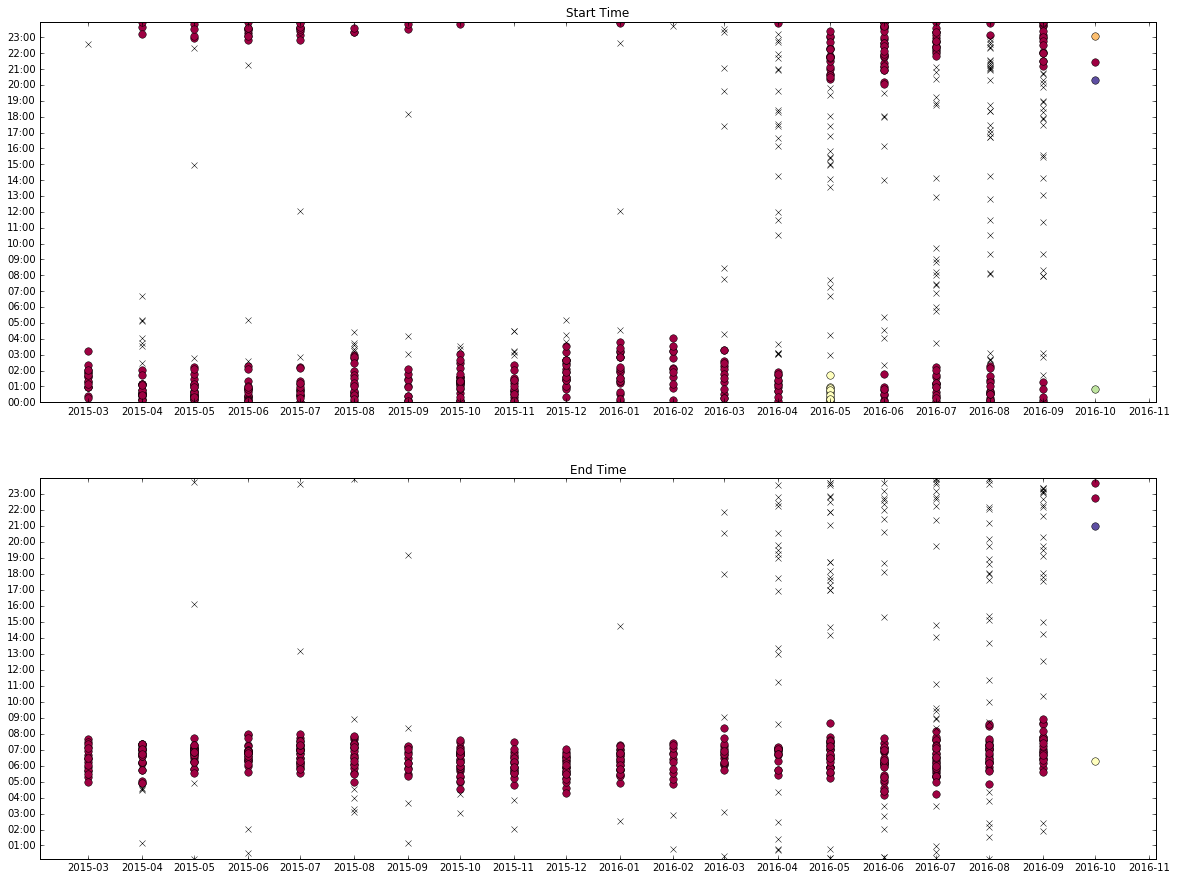

In [8]:



df = pd.read_csv("../Data/sleep/sleep_raw/sleep_S002.csv", delimiter=',', usecols=[x for x in range(2,5)],parse_dates=[0,1])
#df = df[(df.time_start >= pd.to_datetime("2015-03-01")) & (df.time_start < pd.to_datetime("2016-07-01"))]
df = df[(df.time_start >= pd.to_datetime("2015-03-01"))]

fig = plt.figure(figsize=(20,15))
#plt.ylim(pd.to_datetime(['00:00:00']),pd.to_datetime(['23:59:59']))
#plt.xlim(pd.to_datetime(['2016-02']),pd.to_datetime(['2016-07']))

ax_start_time = fig.add_subplot(211)
ax_start_time.xaxis.set_major_locator(MonthLocator())
ax_start_time.xaxis.set_major_formatter(DateFormatter('%Y-%m'))
ax_start_time.xaxis.set_minor_locator(MonthLocator())
ax_start_time.yaxis.set_major_locator(HourLocator())
ax_start_time.yaxis.set_minor_locator(HourLocator())
ax_start_time.yaxis.set_major_formatter(DateFormatter('%H:%M'))
ax_start_time.set_title("Start Time")
ax_start_time.set_xlim(df["time_start"].min()+ relativedelta(months=-1),df["time_start"].max()+ relativedelta(months=1))

ax_end_time = fig.add_subplot(212)
ax_end_time.xaxis.set_major_locator(MonthLocator())
ax_end_time.xaxis.set_major_formatter(DateFormatter('%Y-%m'))
ax_end_time.xaxis.set_minor_locator(MonthLocator())
ax_end_time.yaxis.set_major_locator(HourLocator())
ax_end_time.yaxis.set_minor_locator(HourLocator())
ax_end_time.yaxis.set_major_formatter(DateFormatter('%H:%M'))
ax_end_time.set_title("End Time")
ax_end_time.set_xlim(df["time_end"].min()+ relativedelta(months=-1),df["time_end"].max()+ relativedelta(months=1))


#print(df['time_end'])
#print("there are {} start date".format(len(sorted(set(start_day_list)))))
#print("there are {} end date".format(len(sorted(set(end_day_list)))))
#print(df)
df["start_month"]= df['time_start'].apply(lambda x: x.strftime("%Y-%m"))
#print(df)
start_month_list = sorted(set(df['start_month']))
print(type(start_month_list[0]))
for month in start_month_list:
    df_month = df[df.start_month == month]
    start_day_list = pd.to_datetime(df_month['time_start']).apply(lambda x: x.strftime("%Y-%m-%d"))
    #print(df['time_start'])
    end_day_list = pd.to_datetime(df_month['time_end']).apply(lambda x: x.strftime("%Y-%m-%d"))
    min_pts = int(len(set(start_day_list) & set(end_day_list))/2)
    print("month:{},{}".format(month,min_pts))
    eps = 60 
    time_start_distance_matrix, time_start_minutes = get_distance_from_df(df_month['time_start'])
    # sk-learn dbscan
    time_start_dbscan_label= dbscan(eps, min_pts, time_start_distance_matrix)
    
    plot_monthly_clusters(time_start_dbscan_label,df_month['time_start'].as_matrix(),ax_start_time)
    time_end_distance_matrix, time_end_minutes = get_distance_from_df(df_month['time_end'])
    # sk-learn dbscan
    time_end_dbscan_label = dbscan(eps, min_pts, time_end_distance_matrix)
    
    plot_monthly_clusters(time_end_dbscan_label,df_month['time_end'].as_matrix(),ax_end_time)
    
    
    

In [ ]:
#TEST

fig1 = plt.figure(figsize=(25,25))
df = pd.read_csv("../Data/sleep/sleep_raw/sleep_S001.csv", delimiter=',', usecols=[x for x in range(2,5)],parse_dates=[0,1])


#print(df['time_end'])
#print("there are {} start date".format(len(sorted(set(start_day_list)))))
#print("there are {} end date".format(len(sorted(set(end_day_list)))))

#print(df)
df["start_month"]= df['time_start'].apply(lambda x: x.strftime("%Y-%m"))
#print(df)
start_month_list = sorted(set(df['start_month']))

for month in start_month_list:
    df_month = df[df.start_month == month]
    start_day_list = pd.to_datetime(df_month['time_start']).apply(lambda x: x.strftime("%Y-%m-%d"))
    #print(df['time_start'])
    end_day_list = pd.to_datetime(df_month['time_end']).apply(lambda x: x.strftime("%Y-%m-%d"))
    min_pts = int(len(set(start_day_list) & set(end_day_list))/2)
    eps = 60
    
    
    time_start_distance_matrix, time_start_minutes = get_distance_from_df(df['time_start'])
    # sk-learn dbscan
    time_start_dbscan_label= dbscan(eps, min_pts, time_start_distance_matrix)


    time_end_distance_matrix, time_end_minutes = get_distance_from_df(df['time_end'])
    # sk-learn dbscan
    time_end_dbscan_label = dbscan(eps, min_pts, time_end_distance_matrix)





time_start_distance_matrix, time_start_minutes = get_distance_from_df(df['time_start'])
# sk-learn dbscan
time_start_dbscan_label= dbscan(eps, min_pts, time_start_distance_matrix)


time_end_distance_matrix, time_end_minutes = get_distance_from_df(df['time_end'])
# sk-learn dbscan
time_end_dbscan_label = dbscan(eps, min_pts, time_end_distance_matrix)


ax2 = configure_polar_plot(fig1.add_subplot(111, projection='polar'))
ax2.set_title(" Start_Time and End_Time (Separately)")

trad = np.vectorize(convert_to_radian)
rad_tseries = trad(time_start_minutes)


plot_clusters(time_start_dbscan_label, time_start_minutes, ax2, 0.8)
plot_clusters(time_end_dbscan_label, time_end_minutes, ax2, 0.6)
plt.show()
#print(time_start_dbscan_label)
# sk-learn dbscan
#time_start_radian_dbscan_label, time_start_radian_dbscan_comp,time_start_radian_dbscan_csi= dbscan(eps_radian, min_pts, time_start_radian_distance_matrix)

#print(time_start_radian_dbscan_label)
#print(set(X1_label))


#print(time_start_dbscan_label)



## 